In [56]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os, sys, pickle, time, re, csv
'Download data from:  https://doi.org/10.17605/OSF.IO/3D9R2'

'Download data from:  https://doi.org/10.17605/OSF.IO/3D9R2'

In [47]:
Data_folder='C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/' 
##replace this

In [3]:
'''
####################
###Data structure###
####################


##recording day index
Single days:
    <mouse id>_<recording day date: ddmmyyyy> 
    e.g. ah04_01122021
Double days:
    <mouse id>_<recording day date1: ddmmyyyy>_<recording day date2: ddmmyyyy> 
    e.g. ah04_01122021_02122021


##Day types
Naming:
-single_ABCDonly_days.npy: List of all single days with ABCD tasks (typically 3 unique tasks, 
one of which is occasionally repeated 
at the end)
-combined_ABCDonly_days.npy: List of all concatenated double-days with only ABCD tasks 
-combined_ABCDonly_notone_days.npy: List of concatenated double-days with only ABCD tasks that have sessions 
where the tone on reward a delivery was ommitted from some trials 
-combined_ABCDE_days.npy: List of all concatenated double-days with ABCDE tasks (note: some of these 
also have interleaved ABCD tasks)

All in the MetaData subfolder

##Tasks
Naming: Task_data_<recording_day>.npy
This is the sequence of reward locations used for each session of a given day (which nodes are rewarded in what order)

##Neuronal_activity:
    Awake:
        Naming: Neuron_raw_<recording day>_<awake_session_id>.npy
        Neuron_raw arrays are matrices of shape neurons X bins
        each bin is the spike count in a 25 ms timewindow
        these arrays start at the first trial (i.e. first time the animal finds reward a)
    Awake_sleep:
        Naming: binned_FR_dic_<recording_day>_<Overall_session_id>.npy
        Neuron_raw arrays are matrices of shape neurons X bins
        each bin is the spike count in a 25 ms timewindow
        these arrays start at the first electrophysiology time bin (i.e. not aligned to first trial)
        Note: these are dictionaries not npy files

##Maze locations:
    Naming: Location_raw_<recording day>_<awake_session_id>.npy
    These contain the maze location of the animal in each 25 ms bin 
    Should correspond to the number of bins in Neuron_raw matrix (may be 1 bin off))

    Locations 1-9 are the 9 nodes
    Then the remaining locations 10-21 are the bridges, coded in the "Edge_grid" array. Just subtract 10 and that
    gives you the index of the Edge_grid array which tells you which bridges are being referenced
    e.g. an entry of 10 means index 0 which is array([1, 2]) (i.e. animal is at the the bridge between nodes 1 and 2)

    Edge_grid.npy is in the MetaData subfolder

##XY locations
    Naming: XY_raw_<recording day>_<awake_session_id>.npy
    More precise XY coordinates (e.g. used to calculate animal's instantaenous speed) in 25 ms bins
    Same length as Location array 


##Trial times
    Naming: trialtimes_<recording_day>_<awake_session_id>.npy
    trialtimes arrays are times (in ms) of each state: the first four columns are the start of each state
    the fifth column is the end of the last state (D)

##Tones
    Naming: to add
    Tone times in ms aligned to first trial


Note that you'll have to convert the trial times and tone tomes from ms to bin number to match the neuron 
and location arrays (i.e. divide by 25)

'''

'\n####################\n###Data structure###\n####################\n\n\n##Neuron npy files:\nThese contain the normalized firing rates of each neuron - spikes per frame (frame rate is 60 Hz)\n\nnpy files for each session\nmatrix with dimensions [neuron,trial,bin]\n\n360 bins per trial, every state is 90 bins\n\n##Location npy files:\nThese contain the location of the animal in each bin (should correspond exactly to the neuron bins)\nlocations1-9 are the 9 nodes\n\nThen the remaining locations 10-21 are the bridges, coded in the "Edge_grid" array. just subtract 10 and that\ngives you the index of the Edge_grid array which tells you which bridges are being referenced\ne.g. an entry of 10 means index 0 which is array([1, 2]) (i.e. animal is at the the bridge between nodes 1 and 2)\n\n##task_data\nthis is the task sequence used for that day (which nodes are rewarded in what order)\n\n\n#####Raw data:\n\nNeuron_raw arrays are matrices of shape neurons X bins\neach bin is the firing rate in

In [49]:
##Recording days used
'''These are pairs of days which were spike sorted together to give a total of 6 tasks: animals do 3 tasks a day'''

Recording_days=np.load(Data_folder+'combined_ABCDonly_days.npy')
Recording_days

array(['ab03_01092023_02092023', 'ab03_05092023_06092023',
       'ab03_29082023_30082023', 'ah03_12082021_13082021',
       'ah03_18082021_19082021', 'ah04_01122021_02122021',
       'ah04_05122021_06122021', 'ah04_07122021_08122021',
       'ah04_09122021_10122021', 'ah04_14122021_16122021',
       'ah07_01092023_02092023', 'ah07_27082023_28082023',
       'ah07_29082023_30082023', 'me08_06092021_09092021',
       'me08_10092021_11092021', 'me08_12092021_13092021',
       'me10_09122021_10122021', 'me10_14122021_15122021',
       'me10_17122021_19122021', 'me10_20122021_21122021',
       'me11_01122021_02122021', 'me11_05122021_06122021',
       'me11_07122021_08122021', 'me11_09122021_10122021',
       'me11_12122021_13122021'], dtype='<U22')

In [50]:
##example task array
mouse_recday='ah04_01122021'
session=0
Tasks=np.load(Data_folder+'Task_data_'+mouse_recday+'.npy',allow_pickle=True)

Tasks

array([[1, 4, 5, 7],
       [6, 5, 2, 9],
       [5, 6, 7, 1],
       [1, 4, 5, 7]])

In [51]:
#Edge grid
'''use this to make sense of the location arrays (see data structure above)'''
Edge_grid=np.load(Data_folder+'Edge_grid.npy')
Edge_grid

array([[1, 2],
       [2, 3],
       [1, 4],
       [2, 5],
       [3, 6],
       [4, 5],
       [5, 6],
       [4, 7],
       [5, 8],
       [6, 9],
       [7, 8],
       [8, 9]])

(46, 46178)


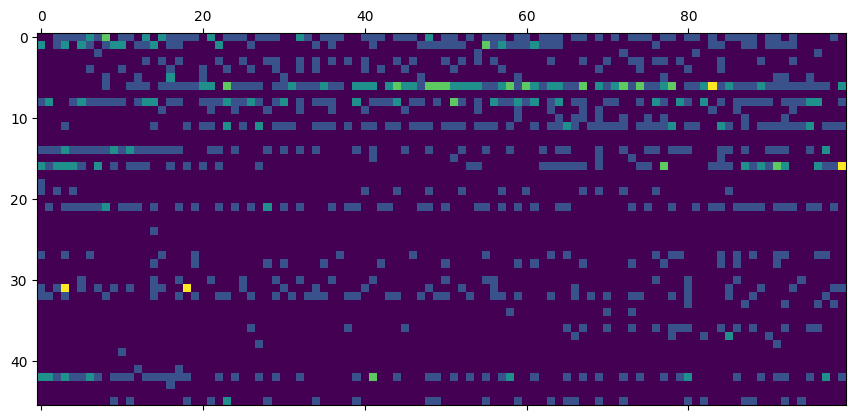

In [52]:
##Example raw neuron activity
mouse_recday='me11_05122021_06122021'
session=0
Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
print(np.shape(Neuron_raw))
plt.matshow(Neuron_raw[:,:100])


In [53]:
##Example raw location
mouse_recday='me11_05122021_06122021'
session=0
Location_raw=np.load(Data_folder+'Location_raw_'+mouse_recday+'_'+str(session)+'.npy')
Location_raw

array([7., 7., 7., ..., 7., 7., 7.])

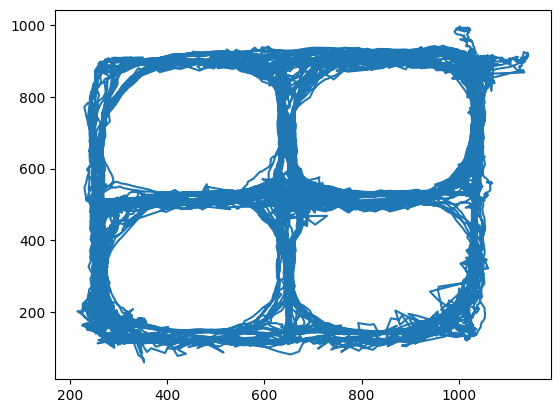

In [45]:
##Example XY coordinates
mouse_recday='me11_05122021_06122021'
session=0

xy_=np.load(Data_folder+'XY_raw_'+mouse_recday+'_'+str(session)+'.npy') 
plt.plot(xy_[:,0],xy_[:,1])


In [54]:
##Example raw trial times
mouse_recday='me11_05122021_06122021'
session=0
Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
Trial_times

array([[      0,   28281,   37530,   52913,   60444],
       [  60444,   71109,   82048,   88885,  100746],
       [ 100746,  105880,  120191,  128263,  141746],
       [ 141746,  158295,  165093,  180260,  191678],
       [ 191678,  195225,  205526,  220191,  225980],
       [ 225980,  236466,  245755,  264650,  273200],
       [ 273200,  277549,  290244,  297799,  306116],
       [ 306116,  310499,  320357,  326988,  333894],
       [ 333894,  338003,  351410,  357431,  365823],
       [ 365823,  371263,  378970,  388377,  395136],
       [ 395136,  399503,  407190,  412171,  419973],
       [ 419973,  425610,  434328,  440071,  447185],
       [ 447185,  451190,  461302,  466944,  471890],
       [ 471890,  476901,  483760,  490162,  496769],
       [ 496769,  502656,  509776,  515424,  522801],
       [ 522801,  526872,  533576,  538595,  549444],
       [ 549444,  555895,  565699,  574145,  583270],
       [ 583270,  589264,  600183,  607608,  615943],
       [ 615943,  620412,  6

Section of Raw data fed in - all neurons


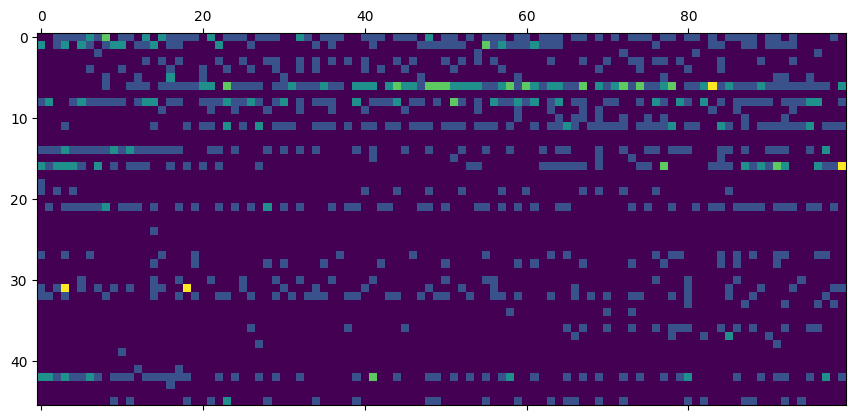

C:\Users\moham\AppData\Local\Temp\ipykernel_52248\824359105.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])


_____
Example output neuron
trials x normalised time bins
dashed lines represent reward times


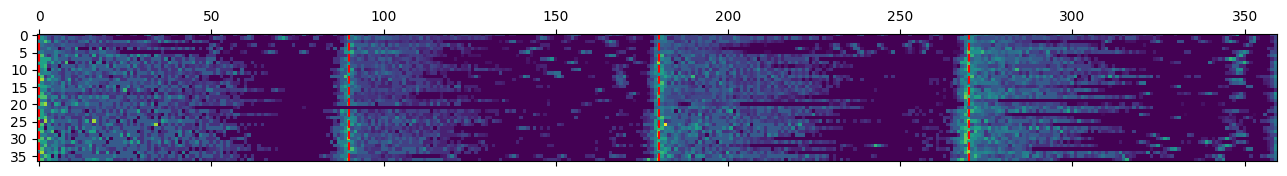

In [55]:
###Normalisation - i.e. how to get from array of raw firing rates and state times to
##normalised firing matrices

###Defining functions
def partition(alist, indices):
    return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])

def normalise(xx,num_bins=90,take_max=False):
    lenxx=len(xx)
    if lenxx<num_bins:
        xx=np.repeat(xx,10)/10
        lenxx=lenxx*10
    indices_polar=np.arange(lenxx)
    if take_max==True:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'max', bins=num_bins)[0]
    else:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'mean', bins=num_bins)[0]
    return(normalized_xx)

def raw_to_norm(raw_neuron,Trial_times_conc,num_states=4,return_mean=True,smoothing=True,\
                take_max=False,smoothing_sigma=10):
    raw_neuron_split=remove_empty(partition(list(raw_neuron),list(Trial_times_conc)))
    if len(raw_neuron_split)%num_states!=0:
        raw_neuron_split=raw_neuron_split[:len(raw_neuron_split)-len(raw_neuron_split)%num_states]
    
    if take_max==True:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii],take_max=True)\
                                          for ii in np.arange(len(raw_neuron_split))])
    else:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii]) for ii in np.arange(len(raw_neuron_split))])
    
    Actual_norm=(raw_neuron_split_norm.reshape(len(raw_neuron_split_norm)//num_states,\
                                               len(raw_neuron_split_norm[0])*num_states))
    
    if return_mean==True:
        Actual_norm_mean=np.nanmean(Actual_norm,axis=0)
        if smoothing==True:
            Actual_norm_smoothed=smooth_circular(Actual_norm_mean,sigma=smoothing_sigma)
            return(Actual_norm_smoothed)
        else:
            return(Actual_norm_mean)
    else:
        return(Actual_norm)

###Example
mouse_recday='me11_05122021_06122021'
session=0
Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
num_trials=len(Trial_times)
num_neurons=len(Neuron_raw)

print('Section of Raw data fed in - all neurons')
plt.matshow(Neuron_raw[:,:100])
plt.show()

##Normalisation
num_bins=90
num_states=4
num_phases=3

Trial_times_conc=np.hstack((np.concatenate(Trial_times[:,:-1]),Trial_times[-1,-1]))//25
Neurons_norm=np.zeros((num_neurons,num_trials,num_bins*num_states))
Neurons_norm[:]=np.nan
for neuron in np.arange(num_neurons):
    Neuron_raw_neuron=Neuron_raw[neuron,:]
    Neuron_raw_neuron_split=partition(list(Neuron_raw_neuron), list(Trial_times_conc))
    Neuron_raw_neuron_split_norm=np.asarray([normalise(Neuron_raw_neuron_split[ii])\
                                             for ii in np.arange(len(Neuron_raw_neuron_split))])
    Neuron_norm=(Neuron_raw_neuron_split_norm.reshape(len(Neuron_raw_neuron_split_norm)//4,\
                                                      len(Neuron_raw_neuron_split_norm[0])*4))
    
    Neurons_norm[neuron]=Neuron_norm
print('_____')
print('Example output neuron')
print('trials x normalised time bins')
print('dashed lines represent reward times')
###plotting example
neuron=0
plt.matshow(Neurons_norm[neuron])
for angle in np.arange(4)*90:
    plt.axvline(angle,color='red',ls='dashed')
plt.show()